# RIXS fast analysis - Sacla

This notebook performs a fast RIXS analysis, using pre-developed routines contained in the `examples` directory.

We start including some matplotlib customizations for the notebook:

In [1]:
import matplotlib as mpl
# loading customized matplotlib style. If not available, it does nothing
try:
    mpl.rcParams = mpl.rc_params_from_file("/swissfel/photonics/sala/sacla/utilities/matplotlibrc")
except:
    pass

# using the NBAgg backend, which allows interactive plots in the Notebook
mpl.use("nbagg")

import matplotlib.pyplot as plt

Then, we load the example file containing the routines. This loads the code in the notebook, so that you can run and change the code interactively. To save it back into the original file, you can use `%save` magic command (type `%save?` to read help)

In [3]:
# %load ../examples/example_rixs.py
# # Sacla - RIXS example
# 
# In this example, some simple code is provided as an example to produce some Resonant Inelastic X-Ray Scattering (RIXS) maps.
# 
# The basic steps to be performed are:
# - select a suitable set of runs
# - scan for finding the scanned monochromator energies
# - produce the spectra for each energy, and the on/off maps
# 
# *The aim of this tutorial is not to produce extremely efficient code, but code as simple and as fast as possible 
# to support the data quality evaluation during beamtime and after.*
# 


import numpy as np
import matplotlib.pyplot as plt
import sys
import h5py
import pandas as pd

# Loading SACLA tools 
SACLA_LIB = "../"
sys.path.append(SACLA_LIB)
import utilities as ut

# specific converters for the 2014-11 data taking. These should be customized per each beamtime!
from utilities import beamtime_converter_201411XX as sacla_converter

# directory containing ROI'd hdf5 files
DIR = "/swissfel/photonics/data/2014-11-26_SACLA_ZnO/hdf5/"
dark_file = "/swissfel/photonics/data/2014-11-26_SACLA_ZnO/dark/dark_256635.h5"

# Then, we define:
# * the SACLA datasets
# * $t_0$

# Define SACLA quantities - they can change from beamtime to beamtime
daq_labels = {}
daq_labels["I0_down"] = "event_info/bl_3/eh_4/photodiode/photodiode_I0_lower_user_7_in_volt"
daq_labels["I0_up"] = "event_info/bl_3/eh_4/photodiode/photodiode_I0_upper_user_8_in_volt"
daq_labels["TFY"] = "event_info/bl_3/eh_4/photodiode/photodiode_sample_PD_user_9_in_volt"
daq_labels["photon_mono_energy"] = "event_info/bl_3/tc/mono_1_position_theta"
daq_labels["delay"] = "event_info/bl_3/eh_4/laser/delay_line_motor_29"
daq_labels["ND"] = "event_info/bl_3/eh_4/laser/nd_filter_motor_26"
daq_labels["photon_sase_energy"] = "event_info/bl_3/oh_2/photon_energy_in_eV"
daq_labels["x_status"] = "event_info/bl_3/eh_1/xfel_pulse_selector_status"
daq_labels["x_shut"] = "event_info/bl_3/shutter_1_open_valid_status"
daq_labels["laser_status"] = "event_info/bl_3/lh_1/laser_pulse_selector_status"
daq_labels["tags"] = "event_info/tag_number_list"

# the t0, to be found experimentally
t0 = 220.86


def get_data_df(dataset_name, runs, selection=""):
    # create a DataFrame
    df_orig = pd.DataFrame(columns=daq_labels.keys(), )

    failed_runs = []
    runs = sorted(runs)
    for run in runs:
        mydict = {}  # temporary dict, where to store data
        fname = DIR + str(run) +"_roi.h5"  # the file name
        try:
            f = h5py.File(fname, "r")
            main_dset = f["run_" + str(run)]
        except:
            print "Error loading run %s: %s" % (run, sys.exc_info[1])
            failed_runs.append(run)
            pass
        # Loading data from the specified datasets
        for k, v in daq_labels.iteritems():
            if k == "delay":
                # delays are in motor steps
                mydict[k] = sacla_converter.convert("delay", main_dset[v][:], t0=t0)
            elif k == "photon_mono_energy":
                # mono energy settings are in motor steps
                mydict[k] = sacla_converter.convert("energy", main_dset[v][:])
            elif k == "photon_sase_energy":
                mydict[k + "_mean"] = main_dset[v][:].mean()
            else:
                mydict[k] = main_dset[v][:]

        tmp_df = pd.DataFrame(data=mydict)
        tmp_df["run"] = run
        # Append the data to the dataframe
        df_orig = df_orig.append(tmp_df)

    # removing failed runs
    for r in failed_runs:
        runs.remove(r)

    # round mono energy and delay
    df_orig.photon_mono_energy = np.round(df_orig.photon_mono_energy.values, decimals=4)
    df_orig.delay = np.round(df_orig.delay.values, decimals=1)

    # create total I0 and absorption coefficients
    df_orig["I0"] = df_orig.I0_up + df_orig.I0_down
    df_orig["absorp"] = df_orig.TFY / df_orig.I0
    df_orig["is_laser"] = (df_orig['laser_status'] == 1)

    # set tag number as index
    df_orig = df_orig.set_index("tags")

    # filtering out garbage
    if selection != "":
        df = df_orig.query(selection)
    else:
        df = df_orig

    # print selection efficiency
    print "\nSelection efficiency"
    sel_eff = pd.DataFrame( {"Total":df_orig.groupby("run").count().ND, 
                             "Selected": df.groupby("run").count().ND, 
                             "Eff.": df.groupby("run").count().ND / df_orig.groupby("run").count().ND})
    print sel_eff

    # checking delay settings
    g = df.groupby(['run', 'delay', 'photon_mono_energy'])
    print "\nEvents per run and delay settings"
    print g.count().TFY
    
    return df, runs


def compute_rixs_spectra(dataset_name, df, thr_low=0, thr_hi=999999, ):
    # In principle, a single run can contain *multiple mono settings*, so we need to load data from all the runs, and the group them by mono energy. `Pandas` can help us with that...
    # We load all data from files, place it in a `DataFrame`, and then add some useful derived quantities. At last, we use `tags` as index for the `DataFrame`

    # label for ascii output dump
    out_label = "rixs_" + runs[0] + "-" + runs[-1]

    delay = df.delay.unique()
    if len(delay) > 1:
        print "More than one delay settings in the selected run range, exiting"
        sys.exit(-1)

    print "\nAvailable energy settings"
    print df.photon_mono_energy.unique(), "\n"

    # Now we can run the analysis. For each energy value and each run, a *list of tags* is created, 
    # such that events have the same mono energy and they are part of the same run (as each run is in a separated file). 
    # For each of these lists, we run the `AnalysisProcessor` and create the required spectra, for laser on and off. 

    # the mono energies contained in the files
    energies_list = sorted(df.photon_mono_energy.unique().tolist())
    fnames = [DIR + str(run) +"_roi.h5" for run in runs]

    # The AnalysisProcessor
    an = ut.analysis.AnalysisProcessor()
    # if you want a flat dict as a result
    an.flatten_results = True

    # add analysis
    an.add_analysis("image_get_spectra", args={'axis': 1, 'thr_low': thr_low, 'thr_hi': thr_hi})
    an.add_analysis("image_get_mean_std", args={'thr_low': thr_low})
    bins = np.arange(-150, 1000, 5)
    an.add_analysis("image_get_histo_adu", args={'bins': bins})
    an.set_sacla_dataset(dataset_name)

    # run the analysis
    n_events = -1
    spectrum_on = None
    spectrum_off = None

    # multiprocessing import
    from multiprocessing import Pool
    from multiprocessing.pool import ApplyResult

    # initialization of the RIXS maps. Element 0 is laser_on_ element 1 is laser_off
    rixs_map = [np.zeros((len(energies_list), 1024)), np.zeros((len(energies_list), 1024))]
    rixs_map_std = [np.zeros((len(energies_list), 1024)), np.zeros((len(energies_list), 1024))]

    n_events = -1
    spectrum = [None, None]
    total_results = {}
    events_per_energy = [{}, {}]

    for i, energy in enumerate(energies_list):
        async_results = []  # list for results

        events_per_energy[0][energy] = 0
        events_per_energy[1][energy] = 0
        energy_masks = []
        # creating the pool
        pool = Pool(processes=8)
        # looping on the runs
        for j, run in enumerate(runs):
            df_run = df[df.run == run]
            energy_masks.append(df_run[df_run.photon_mono_energy == energy])
            # apply the analysis 
            async_results.append(pool.apply_async(an, (fnames[j], n_events, energy_masks[j].index.values)))

        # closing the pool
        pool.close()

        # waiting for all results
        results = [r.get() for r in async_results]
        print "Got results for energy", energy

        # producing the laser on/off maps
        for j, run in enumerate(runs):

            if not total_results.has_key(run):
                total_results[run] = {}

            if not results[j].has_key("spectra"):
                continue

            df_run = df[df.run == run]
            energy_mask = energy_masks[j]
            laser_masks = [None, None]
            if n_events != -1:
                laser_masks[0] = energy_mask.is_laser.values[:n_events]
            else:
                laser_masks[0] = energy_mask.is_laser.values
            laser_masks[1] = ~laser_masks[0]

            for laser in [0, 1]:
                norm = np.count_nonzero(~np.isnan(results[j]["spectra"][laser_masks[laser]][:, 0]))
                events_per_energy[laser][energy] += norm
                spectrum = np.nansum((results[j]["spectra"][laser_masks[laser]].T / df_run[laser_masks[laser]].I0.values).T, axis=0)
                spectrum_events = np.nansum(results[j]["spectra"][laser_masks[laser]], axis=0)
                rixs_map[laser][energies_list.index(energy)] += spectrum
                rixs_map_std[laser][energies_list.index(energy)] += spectrum_events
            
            total_results[run][energy] = {}
            total_results[run][energy]["results"] = results[j]
            total_results[run][energy]["laser_on"] = laser_masks[0]

    for laser in [0, 1]:
        for energy in events_per_energy[0].keys():
            rixs_map[laser][energies_list.index(energy)] /= events_per_energy[laser][energy]
    
        rixs_map_std[laser] = rixs_map[laser] / np.sqrt(rixs_map_std[laser])
        np.savetxt("%s_map_%s_%dps.txt" % (out_label, "on" if laser==0 else "off", delay), rixs_map[laser])

    return rixs_map, rixs_map_std, total_results


def get_rixs_spectra(dataset_name, runs, thr_low=0, thr_hi=999999, selection=""):
    df, runs = get_data_df(dataset_name, runs, selection=selection)
    return compute_rixs_spectra(dataset_name, df, thr_low, thr_hi)


if __name__ == "__main__":
    if len(sys.argv) != 3:
        print "USAGE: %s initial_run_number final_run_number" % sys.argv[0]
    else:
        run_i = int(sys.argv[1])
        run_f = int(sys.argv[2])
        runs = [str(x) for x in np.arange(run_i, run_f + 1)]

        sel = "(x_shut == 1) & (x_status == 1) & (I0_up > 0.01) & (I0_down > 0.01) & (ND > -1) & (photon_mono_energy) > 9"
        rixs_map, rixs_map_std, total_results = get_rixs_spectra("detector_2d_1", runs, thr_low=70, thr_hi=170, selection=sel)

        plt.figure()
        plt.imshow(rixs_map[0] - rixs_map[1], aspect="auto", vmin=-10, vmax=10)
        plt.colorbar()
        plt.show()


USAGE: /gpfs/perf/Other/photonics/sala/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py initial_run_number final_run_number


Let's perform a quick run, using only a lower ADU threshold of 70 counts:

In [4]:
dataset_name = "detector_2d_1"
runs = [str(x) for x in range(258840, 258852)]
sel = "(x_shut == 1) & (x_status == 1) & (I0_up > 0.01) & (I0_down > 0.01)"

df, runs = get_data_df("detector_2d_1", runs, selection=sel)
rixs, rixs_std, results = compute_rixs_spectra(dataset_name, df, thr_low=70, )


Selection efficiency
            Eff.  Selected  Total
run                              
258840  0.975741      5269   5400
258841  0.973704      5258   5400
258842  0.396852      2143   5400
258843  0.966667      5220   5400
258844  0.966852      5221   5400
258845  0.972407      5251   5400
258846  0.959444      5181   5400
258847  0.965370      5213   5400
258848  0.954815      5156   5400
258849  0.945741      5107   5400
258850  0.949630      5128   5400
258851  0.952037      5141   5400

Events per run and delay settings
run     delay  photon_mono_energy
258840  2      9.655                 5269
258841  2      9.656                 5258
258842  2      9.657                 2143
258843  2      9.657                 5220
258844  2      9.657                 5221
258845  2      9.658                 5251
258846  2      9.659                 5181
258847  2      9.660                 5213
258848  2      9.661                 5156
258849  2      9.662                 5107
258850  2    

In [5]:
energies_list = sorted(set([x.keys()[0] for x in results.values()]))
print energies_list

[9.655, 9.656, 9.657, 9.658, 9.659, 9.66, 9.661, 9.662, 9.663, 9.664]


We can check that the RIXS maps have been also dumped as ASCII files:

In [25]:
!ls -lah rixs_258840-258851*.txt

-rw-r--r-- 1 sala sls 250K  8. Mai 12:19 rixs_258840-258851_map_off_2ps.txt
-rw-r--r-- 1 sala sls 250K  8. Mai 12:19 rixs_258840-258851_map_on_2ps.txt


We can plot ADU histograms for each run (there is no threshold on the ADU histograms), together with some proposed ADU cuts (70, 120, 170):

The last bin contains the sum of all bins left out of the plot


/swissfel/photonics/sala/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'Arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


<IPython.core.display.Javascript object>


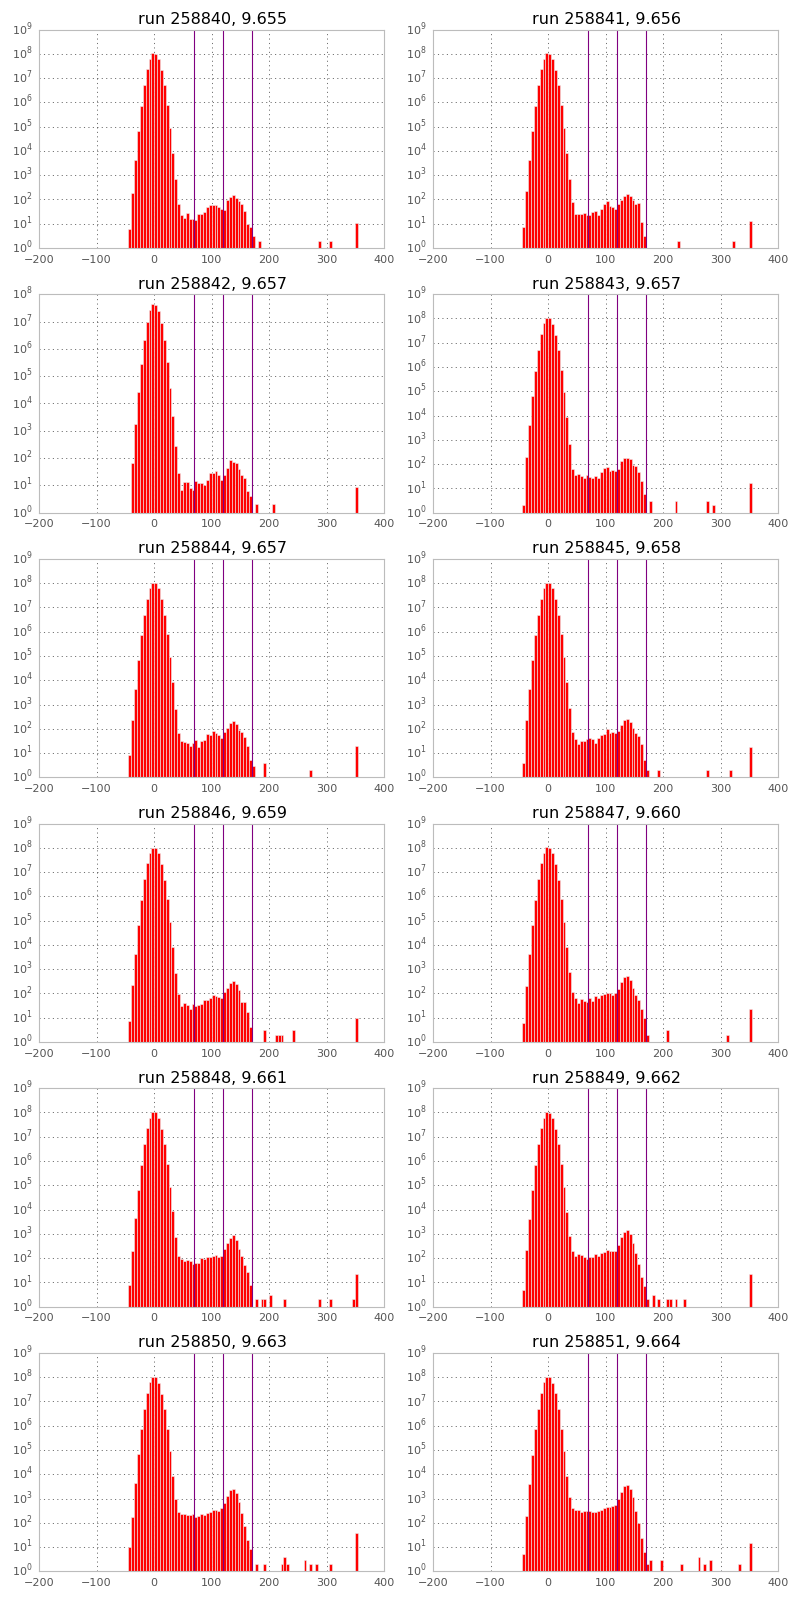

In [6]:
plt.figure(figsize=(10, 20))

ncols = 2
i = 1

print "The last bin contains the sum of all bins left out of the plot"
for k, v in sorted(results.iteritems()):
    run = k
    for kk, vv in v.iteritems():
        ax = plt.subplot(int(len(runs) / ncols), ncols, i) 
        energy = kk
        bins = vv["results"]["histo_adu_bins"][:-1]
        bvals = vv["results"]["histo_adu"].copy()
        max_bin = 100
        bvals[max_bin] += bvals[max_bin:].sum()
        bvals2 = bvals[:max_bin + 1]
        ax.bar(bins[:max_bin+1], bvals2, log=True, label=run, 
               width=bins[1] - bins[0])
        ax.set_title("run %s, %.3f" %(run, energy))
        ax.axvline(70)
        ax.axvline(120)
        ax.axvline(170)
        i += 1
       
plt.tight_layout()
plt.show()

Let's see the RIXS plane, and how it compares with XAS:

In [7]:
# Getting XAS
delay = 2
# setting mono energy as index, as this is an energy scan:
data_df = df.set_index('photon_mono_energy')
# creating a laser_on/off dataframes
data_df_on = data_df[data_df.laser_status == 1]
data_df_off = data_df[data_df.laser_status == 0]

df_on = data_df_on.absorp.mean(level=0)
df_off = data_df_off.absorp.mean(level=0)

df_xas = df_on - df_off
# get standard error, using .sem() method
df_on_std = data_df_on.absorp.sem(level=0)
df_off_std = data_df_off.absorp.sem(level=0)
df_xas_err = np.sqrt((df_on_std) * (df_on_std) + (df_off_std) * (df_off_std))

<IPython.core.display.Javascript object>


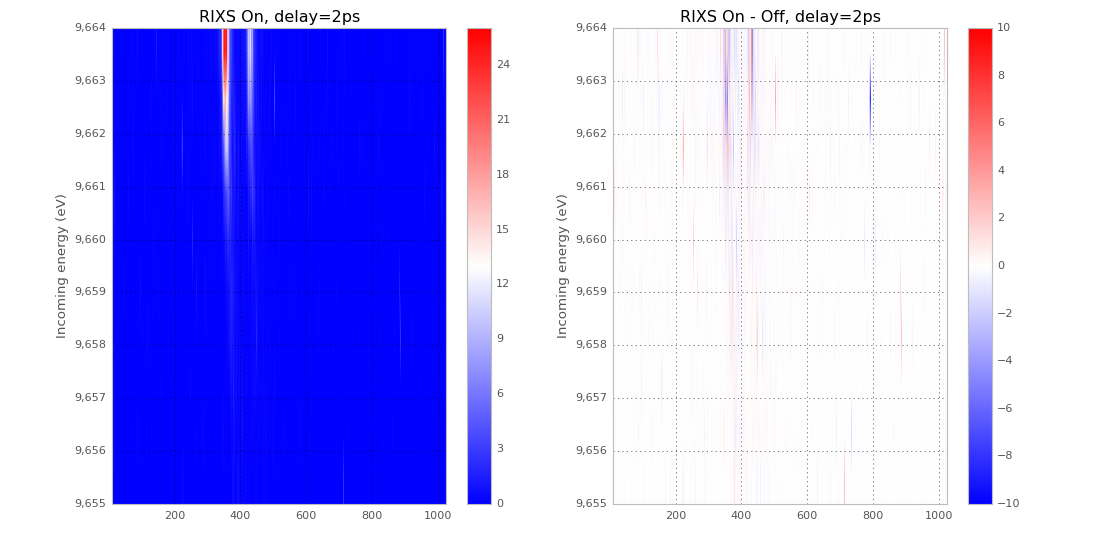

<IPython.core.display.Javascript object>


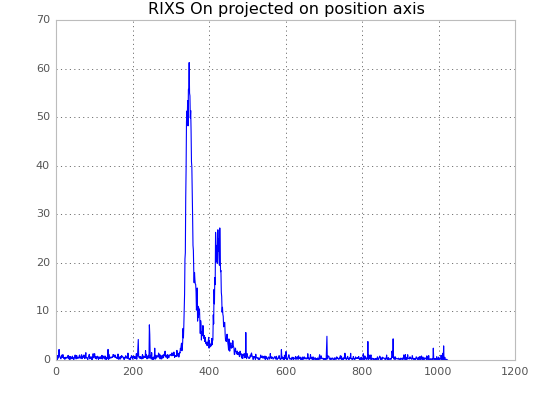

<IPython.core.display.Javascript object>


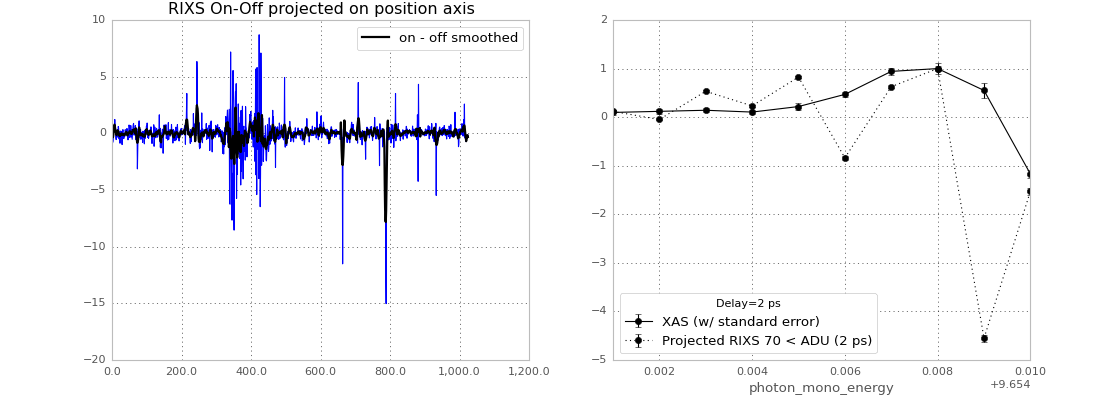

In [27]:
# RIXS maps
plt.figure(figsize=(14, 7))
ax = plt.subplot(121)
imgplot = ax.imshow(rixs[0],
               origin="lower",
               extent=(rixs[0].shape[0], rixs[0].shape[1], 1000 * energies_list[0], 1000 * energies_list[-1]),
               aspect="auto", cmap="bwr",
            #interpolation="bilinear",
                    #vmax=3000, vmin=-3000
           )
ax.get_yaxis().set_major_formatter( mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.colorbar(imgplot)
plt.title("RIXS On, delay=2ps")
plt.ylabel("Incoming energy (eV)")

ax = plt.subplot(122)
imgplot = ax.imshow((rixs[0] - rixs[1]),
           origin="lower",
           extent=(rixs[0].shape[0], rixs[0].shape[1], 1000 * energies_list[0], 1000 * energies_list[-1]),
           aspect="auto", cmap="bwr",vmax=10, vmin=-10
           )

ax.get_yaxis().set_major_formatter( mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.colorbar(imgplot)
plt.title("RIXS On - Off, delay=2ps")
plt.ylabel("Incoming energy (eV)")

### plot
plt.figure(figsize=(7, 5))
plt.title("RIXS On projected on position axis")
plt.plot((rixs[0]).sum(axis=0))

plt.figure(figsize=(14, 5))
ax = plt.subplot(121)
plt.title("RIXS On-Off projected on position axis")
plt.plot((rixs[0] - rixs[1]).sum(axis=0))
from scipy.signal import savgol_filter
plt.plot(savgol_filter((rixs[0] - rixs[1]).sum(axis=0), 11, 3), "k", label="on - off smoothed", linewidth=2)
plt.legend(loc='best')

plt.subplot(122)
(df_xas / df_xas.max()).plot(label="XAS (w/ standard error)", color="k", 
                             linestyle="-", marker="o", yerr=df_xas_err / df_xas.max())

rixs_map = rixs[0] - rixs[1]
rixs_proj = rixs_map.sum(axis=1)
# poissonian error?
rixs_proj_std = np.sqrt(np.nansum(np.square(rixs_std[0]) + np.square(rixs_std[1]), axis=1))

plt.errorbar(energies_list, rixs_proj / np.fabs(rixs_proj.max()), 
             rixs_proj_std / np.fabs(rixs_proj.max()), fmt="k:o", 
             label="Projected RIXS 70 < ADU (2 ps)")

ax.get_xaxis().set_major_formatter( mpl.ticker.FuncFormatter(lambda x, p: format(float(x), ',')))
plt.legend(loc="best", title="Delay=" + str(delay) + " ps")
plt.show()

Too many spikes... possibly due to the events with high ADU counts (random firing pixels?). Let's run the analysis with different ADU cuts, and compare with XAS:

In [11]:
runs = [str(x) for x in range(258840, 258852)]
sel = "(x_shut == 1) & (x_status == 1) & (I0_up > 0.01) & (I0_down > 0.01) & (ND > -1)"
rixs_lo110hi, rixs_std_lo110hi, results_lo110hi = compute_rixs_spectra(dataset_name, df,
                                                                       thr_low=110, thr_hi=170)


Available energy settings
[ 9.655  9.656  9.657  9.658  9.659  9.66   9.661  9.662  9.663  9.664] 

[INFO] Setting a new dataset, removing stored preprocess functions. To overcome this, use remove_preprocess=False
Got results for energy 9.655
Got results for energy 9.656
Got results for energy 9.657
Got results for energy 9.658
Got results for energy 9.659
Got results for energy 9.66
Got results for energy 9.661
Got results for energy 9.662
Got results for energy 9.663
Got results for energy 9.664


In [13]:
rixs_lohi, rixs_std_lohi, results_lohi = compute_rixs_spectra(dataset_name, df,
                                                              thr_low=70, thr_hi=170)


Available energy settings
[ 9.655  9.656  9.657  9.658  9.659  9.66   9.661  9.662  9.663  9.664] 

[INFO] Setting a new dataset, removing stored preprocess functions. To overcome this, use remove_preprocess=False
Got results for energy 9.655
Got results for energy 9.656
Got results for energy 9.657
Got results for energy 9.658
Got results for energy 9.659
Got results for energy 9.66
Got results for energy 9.661
Got results for energy 9.662
Got results for energy 9.663
Got results for energy 9.664


<IPython.core.display.Javascript object>


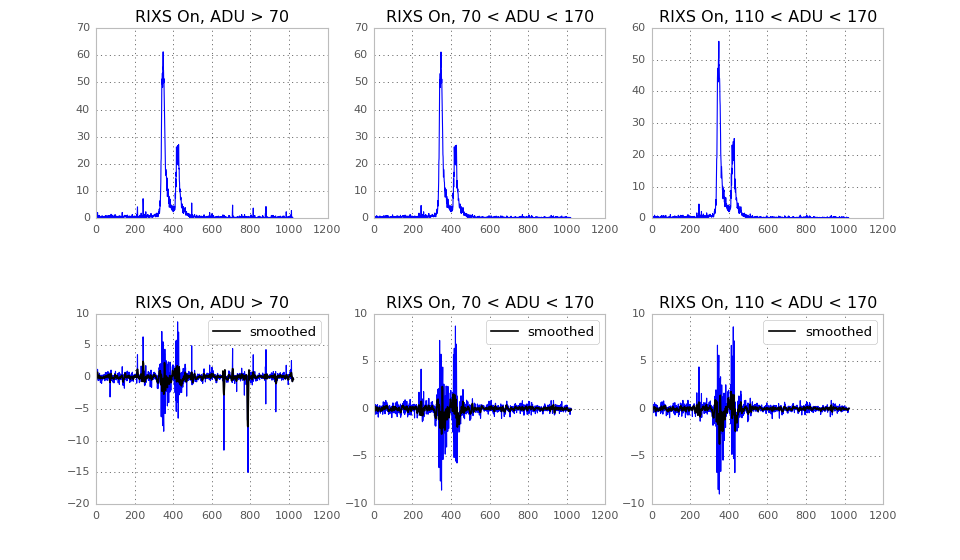

<IPython.core.display.Javascript object>


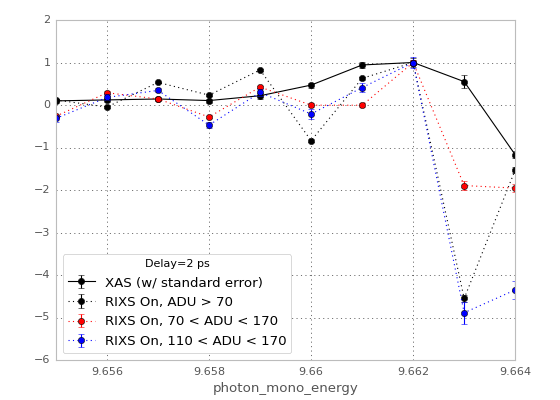

In [31]:
### plot
labels = ["RIXS On, ADU > 70", "RIXS On, 70 < ADU < 170", "RIXS On, 110 < ADU < 170"]
maps = [rixs, rixs_lohi, rixs_lo110hi]

plt.figure(figsize=(12, 7))
for i in range(0, 3):
    plt.subplot(2, 3, i + 1)
    plt.title(labels[i])
    plt.plot((maps[i][0]).sum(axis=0))
    plt.subplot(2, 3, 4 + i)
    plt.title(labels[i])
    plt.plot((maps[i][0] - maps[i][1]).sum(axis=0))
    plt.plot(savgol_filter((maps[i][0] - maps[i][1]).sum(axis=0), 11, 3), "k", label="smoothed", linewidth=1.5)
    plt.legend(loc='best')

plt.figure(figsize=(7,5))
ax = plt.subplot(111)
(df_xas / df_xas.max()).plot(label="XAS (w/ standard error)", color="k", 
                             linestyle="-", marker="o", yerr=df_xas_err / df_xas.max())

rixs_map = []
rixs_proj = []
rixs_proj_std = []
colors = ['k', 'r', 'b', 'g']
for i in range(0, 3):
    rixs_map.append(maps[i][0] - maps[i][1])
    rixs_proj.append(rixs_map[-1].sum(axis=1))
    # poissonian error?
    rixs_proj_std.append(np.sqrt(np.nansum(np.square(rixs_std[-1]) + np.square(rixs_std[-1]), axis=1)))
    plt.errorbar(energies_list, rixs_proj[-1] / np.fabs(rixs_proj[-1].max()), 
             rixs_proj_std[-1] / np.fabs(rixs_proj[-1].max()), fmt=colors[i] + ":o", 
             label=labels[i])
ax.get_xaxis().set_major_formatter( mpl.ticker.FuncFormatter(lambda x, p: format(float(x), ',')))
plt.legend(loc="best", title="Delay=" + str(delay) + " ps")

plt.show()

Cutting too low in ADU can spoil the XAS projection... and at least for one energy (9.663 keV) XAS is not well reproduced. 

The ADU peak structure can be due to diffuse scattering, as can be seen looking at the average of all the images:

<IPython.core.display.Javascript object>


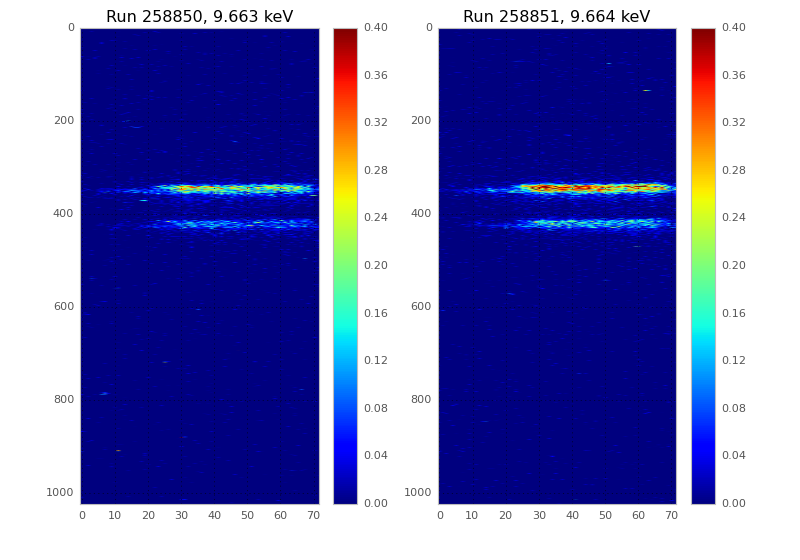

<IPython.core.display.Javascript object>


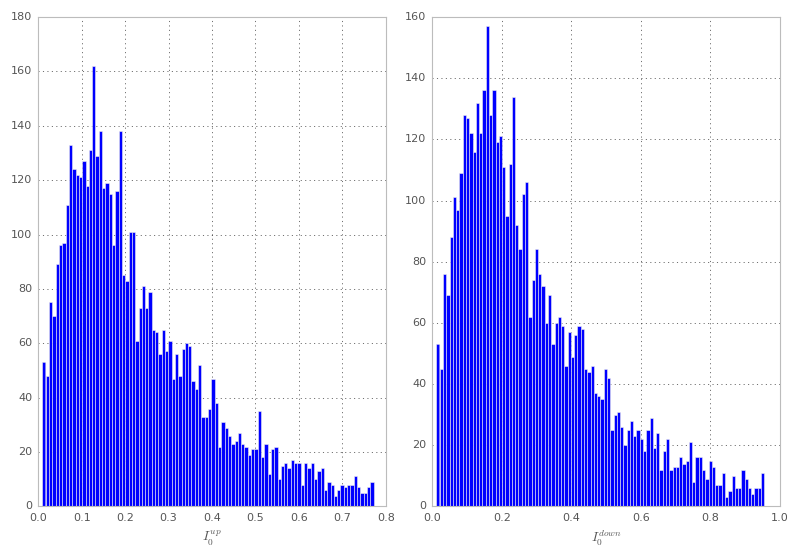

In [217]:
plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.title("Run 258850, 9.663 keV")
plt.imshow(results_lo['258850'][9.663]["results"]["images_mean"], aspect="auto", vmax=0.40)
plt.colorbar()
plt.subplot(122)
plt.title("Run 258851, 9.664 keV")
plt.imshow(results_lo['258851'][9.664]["results"]["images_mean"], aspect="auto", vmax=0.40)
plt.colorbar()

plt.figure(figsize=(10, 7))
plt.subplot(121)
df[(df.run=='258850')].I0_up.hist(bins=100)
plt.xlabel("$I_0^{up}$")
plt.subplot(122)
df[(df.run=='258850')].I0_down.hist(bins=100)
plt.xlabel("$I_0^{down}$")

plt.tight_layout()
plt.show()


In conclusion, this is the RIXS map for $70 < ADU < 170$:

<IPython.core.display.Javascript object>


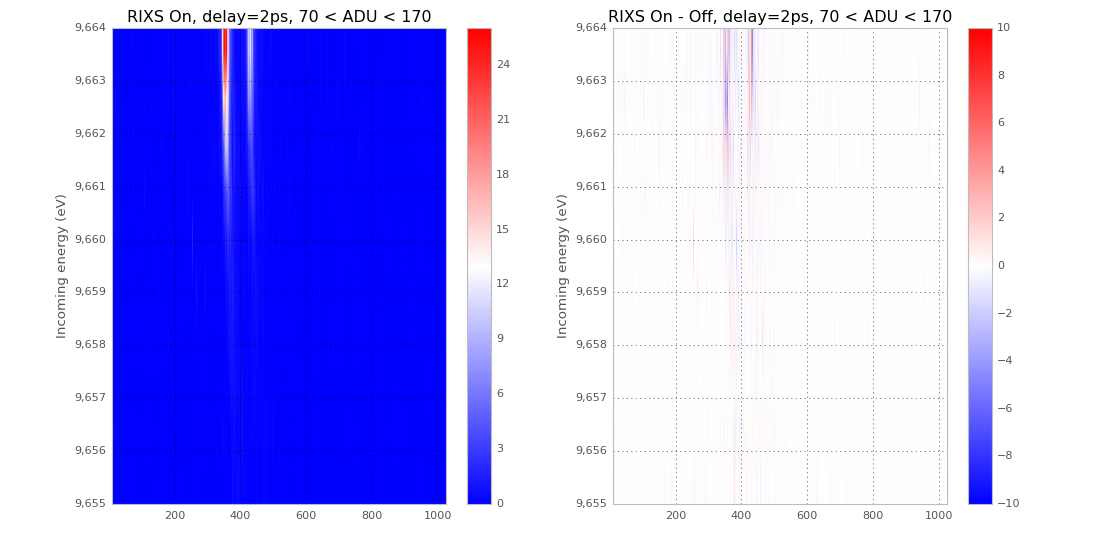

In [213]:
# RIXS maps
plt.figure(figsize=(14, 7))
ax = plt.subplot(121)
imgplot = ax.imshow(rixs_on_lohi,
           origin="lower",
           extent=(rixs_on_lo.shape[0], rixs_on_lo.shape[1], 1000 * energies_list[0], 1000 * energies_list[-1]),
           aspect="auto",
           #interpolation="bilinear",
           cmap="bwr",
           #vmax=3000, vmin=-3000
           )

ax.get_yaxis().set_major_formatter( mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.colorbar(imgplot)
plt.title("RIXS On, delay=2ps, 70 < ADU < 170")
plt.ylabel("Incoming energy (eV)")

ax = plt.subplot(122)
imgplot = ax.imshow((rixs_on_lohi - rixs_off_lohi),
           origin="lower",
           extent=(rixs_on_lo.shape[0], rixs_on_lo.shape[1], 1000 * energies_list[0], 1000 * energies_list[-1]),
           aspect="auto",
           #interpolation="bilinear",
           cmap="bwr",
           vmax=10, vmin=-10
           )

ax.get_yaxis().set_major_formatter( mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.colorbar(imgplot)
plt.title("RIXS On - Off, delay=2ps, 70 < ADU < 170")
plt.ylabel("Incoming energy (eV)")
plt.show()